In [57]:
# Setting up environment

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import joblib

from sklearn.preprocessing import StandardScaler

from dotenv import load_dotenv

load_dotenv()
mpl.rcParams['figure.figsize'] = (12, 10)

In [58]:
# drop colomn
def dropColomn(df, col):
    try:
        df = df.drop(col,1)
    except:
        print('colomn {0} not found'.format(col))
    return df

# split dataframe to feature target numpy array
def split_feature_label(df):
    return df.iloc[:, :-1].values, df.iloc[:, -1].values

In [59]:
# processing testing dataset

# import dataset
test_df = pd.read_csv(os.getcwd()+'/datasets/testing.csv')
# drop colomn id
test_df = dropColomn(test_df, 'id')

# split features and labels
x_test, y_test = split_feature_label(test_df)

print('shape of testing feature: {0}'.format(x_test.shape))
print('shape of testing labels: {0}'.format(y_test.shape))

shape of testing feature: (542, 14)
shape of testing labels: (542,)


In [60]:
# processing training dataset
# import dataset
dataset = pd.read_csv(os.getcwd()+'/datasets/sampled_dataset.csv')

# drop colomm id
dataset = dropColomn(dataset, 'id')

# split features and labels
x,y = split_feature_label(dataset)

print('shape of training feature: {0}'.format(x.shape))
print('shape of training labels: {0}'.format(y.shape))


shape of training feature: (3676, 14)
shape of training labels: (3676,)


In [72]:
dataset.head()

,age,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,59.006386,0.0,0.0,0.0,0.0,0.0,1.0,0.0,254.232674,148.484035,89.993614,26.497322,75.231086,83.783049,1.0
1,56.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,251.271739,126.500000,76.000000,26.181630,73.760870,86.569767,1.0
2,39.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,222.401460,112.000000,71.000000,24.771159,75.848921,79.451613,0.0
3,48.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,231.847328,127.000000,81.000000,25.750299,76.664179,79.008197,0.0
4,63.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,246.612903,155.500000,98.000000,26.627391,74.301075,83.758621,1.0


In [61]:
# split to training and validating dataset
from sklearn.model_selection import train_test_split

TESTSIZE = float(os.getenv('VALRATE'))
TESTRANDOMSTATE = int(os.getenv('VALRANDOMSTATE'))

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = TESTSIZE, random_state = TESTRANDOMSTATE)

print('shape of training feature: {0}'.format(x_train.shape))
print('shape of training labels: {0}'.format(y_train.shape))

print('shape of validation feature: {0}'.format(x_val.shape))
print('shape of validation labels: {0}'.format(y_val.shape))


shape of training feature: (2757, 14)
shape of training labels: (2757,)
shape of validation feature: (919, 14)
shape of validation labels: (919,)


In [62]:
# Scaling data using standar scaler
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_val = sc.transform(x_val)
x_test = sc.transform(x_test)

# save scaler variable into file
scaler_filename = os.getenv("SCALER_FILENAME")
joblib.dump(sc, scaler_filename) 


['model/scaler.save']

In [63]:
# building model

BATCH_SIZE = int(os.getenv('BATCHSIZE'))
EPOCHS = int(os.getenv('EPOCH'))

METRICS = [
    # keras.metrics.TruePositives(name='tp'),
    # keras.metrics.FalsePositives(name='fp'),
    # keras.metrics.TrueNegatives(name='tn'),
    # keras.metrics.FalseNegatives(name='fn'), 
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    # keras.metrics.AUC(name='auc'),
    # keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS ):
    model = keras.Sequential([
        keras.layers.Dense(
            32, activation='relu',
            input_shape=(x_train.shape[-1],)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(
            24, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(
            16, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics)

    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=32,
    mode='max',
    restore_best_weights=True)

In [64]:
model = make_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                480       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 24)                792       
_________________________________________________________________
dropout_10 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 16)                400       
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [65]:
zero_bias_history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    callbacks=early_stopping)

Epoch 1/1024
44/44 [==============================] - 1s 7ms/step - loss: 0.7088 - accuracy: 0.5383 - precision: 0.5316 - recall: 0.5902 - val_loss: 0.6574 - val_accuracy: 0.6442 - val_precision: 0.6946 - val_recall: 0.5456
Epoch 2/1024
44/44 [==============================] - 0s 2ms/step - loss: 0.6836 - accuracy: 0.5745 - precision: 0.5772 - recall: 0.5354 - val_loss: 0.6426 - val_accuracy: 0.6746 - val_precision: 0.7172 - val_recall: 0.6030
Epoch 3/1024
44/44 [==============================] - 0s 2ms/step - loss: 0.6694 - accuracy: 0.5934 - precision: 0.5973 - recall: 0.5559 - val_loss: 0.6287 - val_accuracy: 0.6921 - val_precision: 0.7196 - val_recall: 0.6539
Epoch 4/1024
44/44 [==============================] - 0s 2ms/step - loss: 0.6558 - accuracy: 0.6014 - precision: 0.6040 - recall: 0.5727 - val_loss: 0.6210 - val_accuracy: 0.6942 - val_precision: 0.7111 - val_recall: 0.6794
Epoch 5/1024
44/44 [==============================] - 0s 2ms/step - loss: 0.6508 - accuracy: 0.6235 - pr

In [66]:
model.save('model/ann_model/')

INFO:tensorflow:Assets written to: model/ann_model/assets


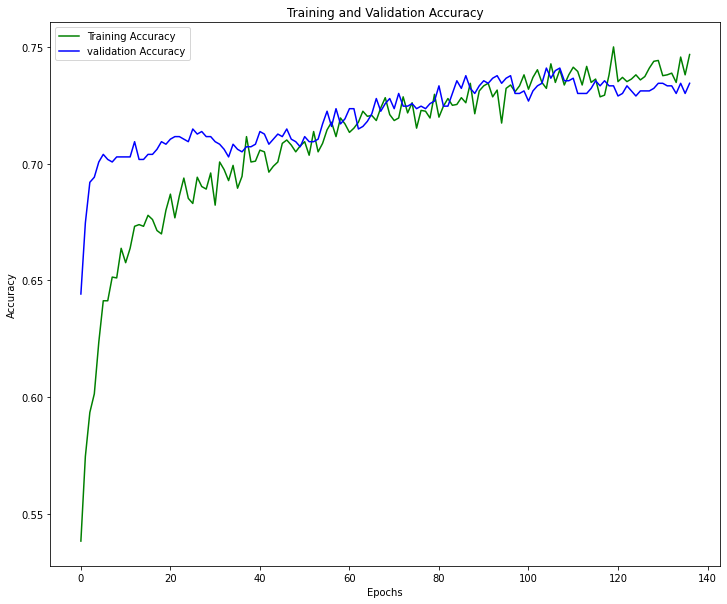

In [67]:
loss_train = zero_bias_history.history['accuracy']
loss_val = zero_bias_history.history['val_accuracy']
epochs = range(len(zero_bias_history.history['accuracy']))
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

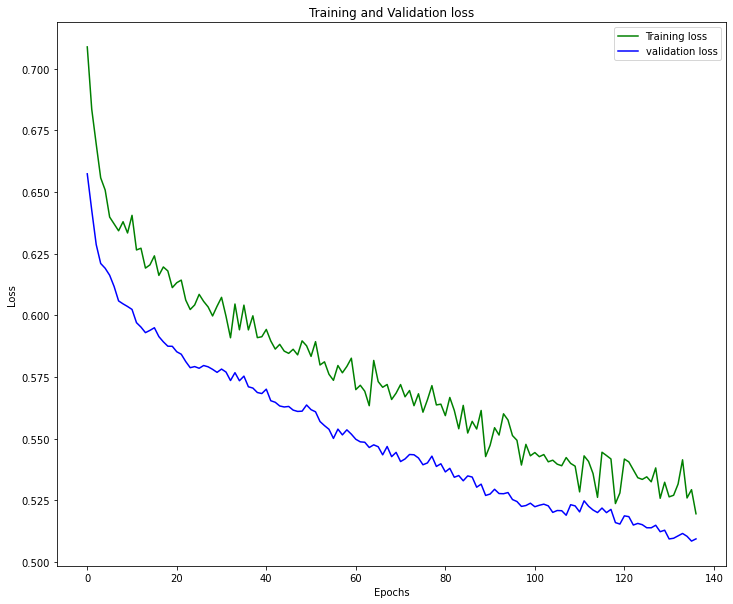

In [68]:
loss_train = zero_bias_history.history['loss']
loss_val = zero_bias_history.history['val_loss']
epochs = range(len(zero_bias_history.history['loss']))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): {0}, with percentage : {1}'.format(cm[0][0], cm[0][0]/len(labels)))
    print('Legitimate Transactions Incorrectly Detected (False Positives): {0}, with percentage : {1}'.format(cm[0][1], cm[0][1]/len(labels)))
    print('Fraudulent Transactions Missed (False Negatives): {0}, with percentage : {1}'.format(cm[1][0], cm[1][0]/len(labels)))
    print('Fraudulent Transactions Detected (True Positives): {0}, with percentage : {1}'.format(cm[1][1], cm[1][1]/len(labels)))
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

    print('Accuracy : ', accuracy_score(labels, predictions > p))

[[0.62392521 0.        ]
 [0.39392427 0.        ]
 [0.31399351 0.        ]
 ...
 [0.54595542 0.        ]
 [0.31198037 1.        ]
 [0.93011492 1.        ]]
Legitimate Transactions Detected (True Negatives): 374, with percentage : 0.6900369003690037
Legitimate Transactions Incorrectly Detected (False Positives): 86, with percentage : 0.15867158671586715
Fraudulent Transactions Missed (False Negatives): 47, with percentage : 0.08671586715867159
Fraudulent Transactions Detected (True Positives): 35, with percentage : 0.06457564575645756
Total Fraudulent Transactions:  82
Accuracy :  0.7546125461254612


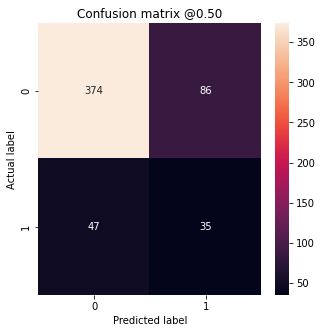

In [70]:
# predicting test data
y_pred = model.predict(x_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
plot_cm(y_test, y_pred)

[[0.33806497 1.        ]
 [0.4106521  0.        ]
 [0.90616977 1.        ]
 ...
 [0.67196155 1.        ]
 [0.27530786 1.        ]
 [0.72316307 1.        ]]
Legitimate Transactions Detected (True Negatives): 381, with percentage : 0.41458106637649617
Legitimate Transactions Incorrectly Detected (False Positives): 67, with percentage : 0.07290533188248095
Fraudulent Transactions Missed (False Negatives): 171, with percentage : 0.18607181719260066
Fraudulent Transactions Detected (True Positives): 300, with percentage : 0.3264417845484222
Total Fraudulent Transactions:  471
Accuracy :  0.7410228509249184


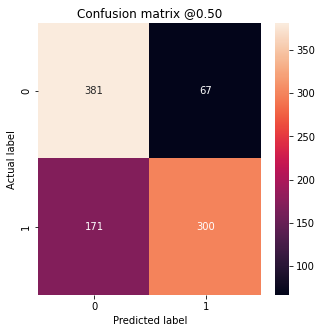

In [71]:
# conf matrix on validation data

y_pred = model.predict(x_val)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_val.reshape(len(y_val),1)),1))

plot_cm(y_val, y_pred)